In [173]:
# Install required libraries for splitting and visualizing data

!pip install split-folders
!pip install plotly

In [174]:
# Core Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
# Image Processing

import splitfolders
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense


# TensorFlow and Keras

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



import random
import splitfolders  

In [175]:
data_dir='/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
output_dir = 'output'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    file_path=os.path.join(data_dir,fold)
    if not os.path.isdir(file_path): 
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepath.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepath,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)

In [176]:
df

,filepaths,labels
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
...,...,...
74995,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74996,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74997,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74998,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala


In [177]:
count=df['labels'].value_counts()
count

labels
Karacadag    15000
Basmati      15000
Jasmine      15000
Arborio      15000
Ipsala       15000
Name: count, dtype: int64

# Start Visualization

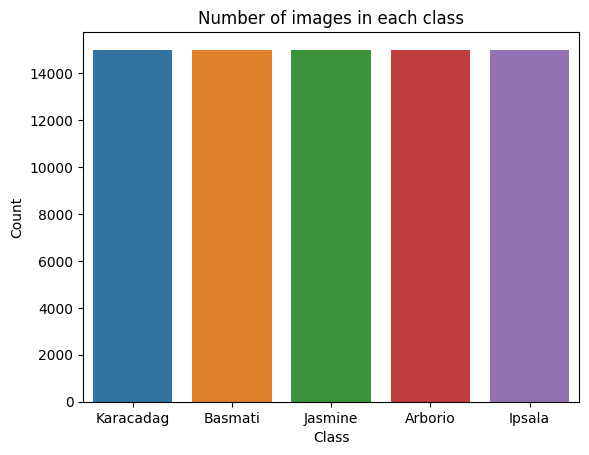

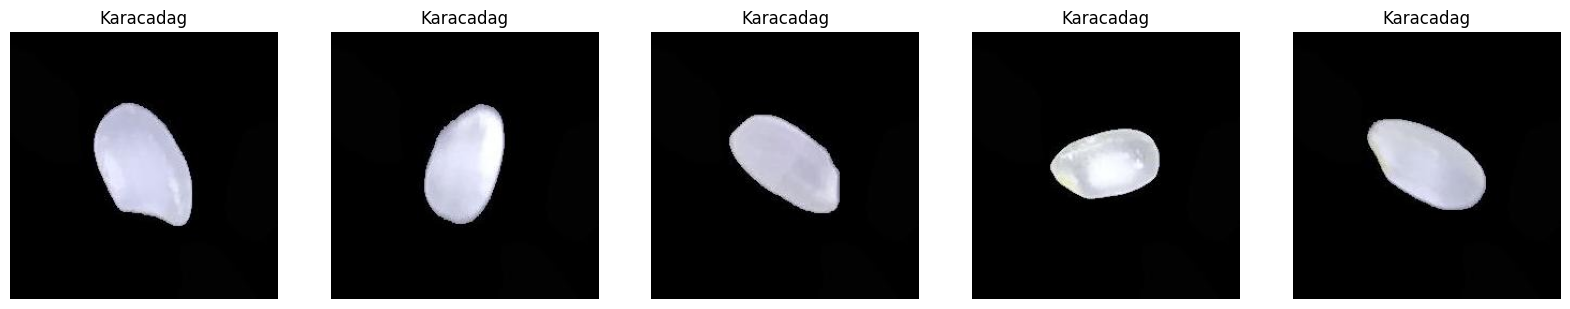

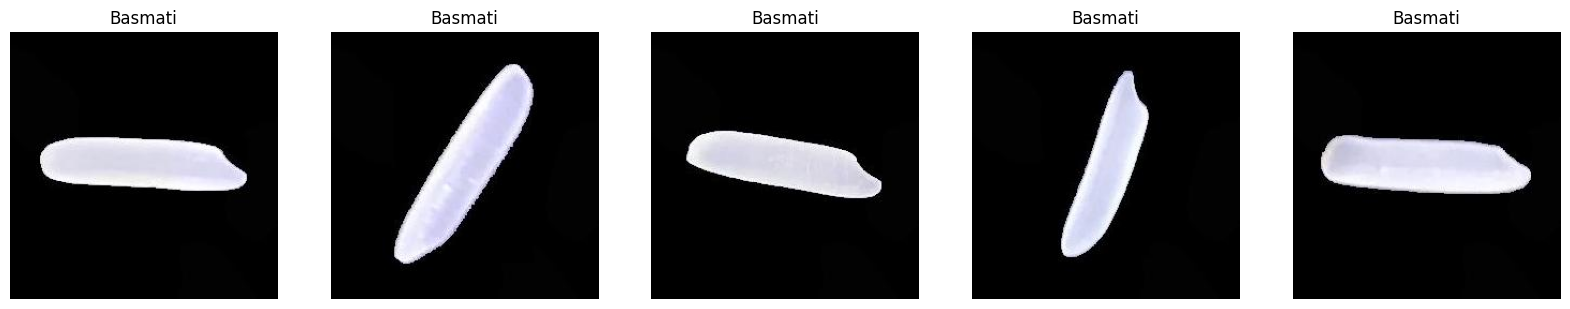

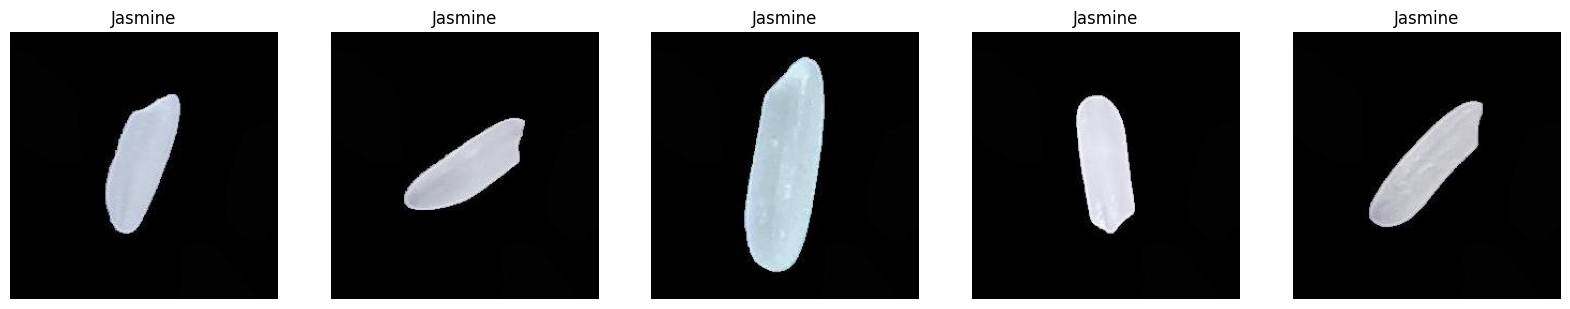

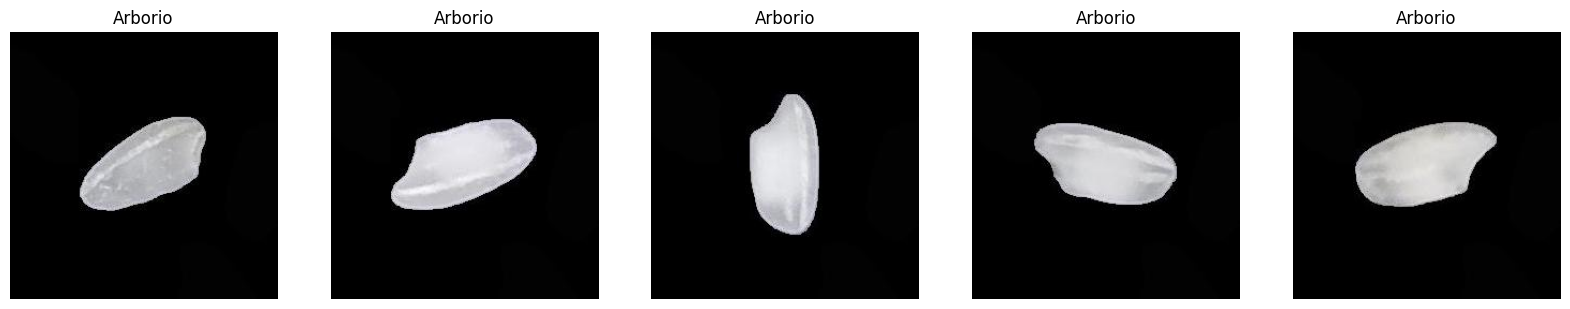

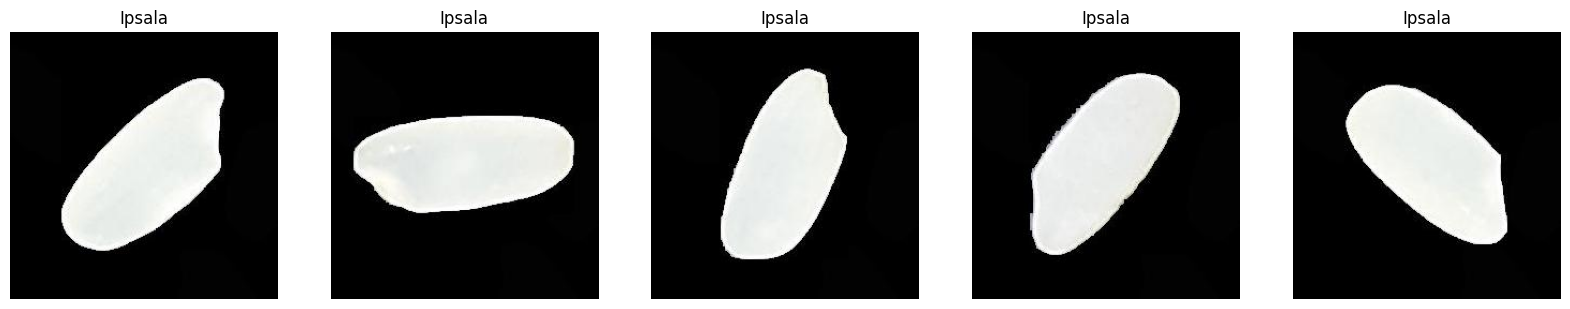

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# graph showing the number of images in each class
sns.countplot(x='labels', data=df)
plt.title('Number of images in each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Showing 5 random images from each class
for label in df['labels'].unique():
    label_df = df[df['labels'] == label]
    random_files = random.sample(list(label_df['filepaths']), 5)
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i, file in enumerate(random_files):
        img = plt.imread(file)
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.show()


# Define Data Paths:

In [179]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Split Data (Optional, using splitfolders):

In [180]:
splitfolders.ratio(data_dir, output='output', seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 75000 files [02:51, 437.13 files/s] 


# Define Image Parameters:

In [181]:
batch_size = 64
img_height = 180
img_width = 180

# Load Data:

In [182]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  
    label_mode='int',  
    image_size=(img_height, img_width),
    interpolation='nearest', 
    batch_size=batch_size,
    shuffle=True 
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False  
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False  
)

Found 60000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


# Define and Compile Model:

In [183]:
num_classes = 5  

model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [184]:
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the Model:

In [185]:
# Define early stopping callback with patience rate
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)

# Define model checkpointing callback
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')


epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.8853 - loss: 0.3525 - val_accuracy: 0.9795 - val_loss: 0.0599
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9785 - loss: 0.0643 - val_accuracy: 0.9904 - val_loss: 0.0300
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9870 - loss: 0.0402 - val_accuracy: 0.9903 - val_loss: 0.0275
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9901 - loss: 0.0295 - val_accuracy: 0.9933 - val_loss: 0.0203
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.9940 - val_loss: 0.0188
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9935 - loss: 0.0201 - val_accuracy: 0.9935 - val_loss: 0.0190
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9941 - loss: 0.0189 - val_accuracy: 0.9939 - val_loss: 0.0188
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9942 - loss: 0.0178 - 

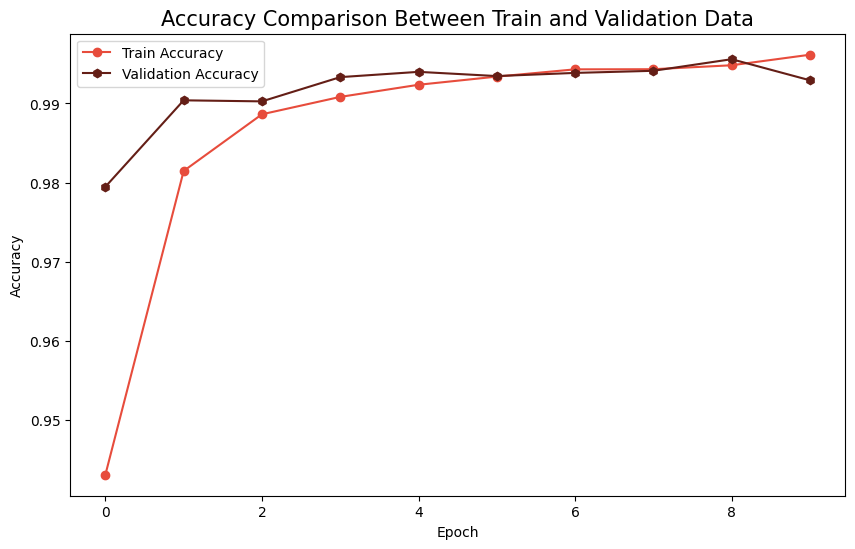

In [192]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, color="#E74C3C", marker='o', label='Train Accuracy')
plt.plot(val_loss, color='#641E16', marker='h', label='Validation Accuracy')
plt.title('Accuracy Comparison Between Train and Validation Data', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [193]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)

val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print('\nValidation accuracy:', val_acc)

118/118 - 3s - 23ms/step - accuracy: 0.9933 - loss: 0.0237

Test accuracy: 0.9933333396911621
118/118 - 3s - 22ms/step - accuracy: 0.9929 - loss: 0.0210

Validation accuracy: 0.9929333329200745


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


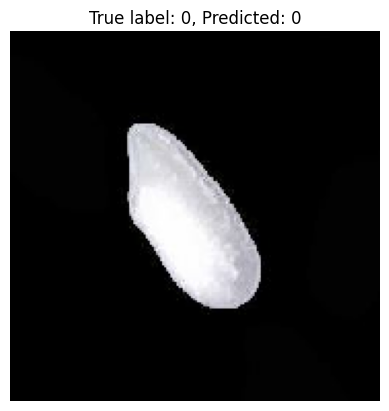

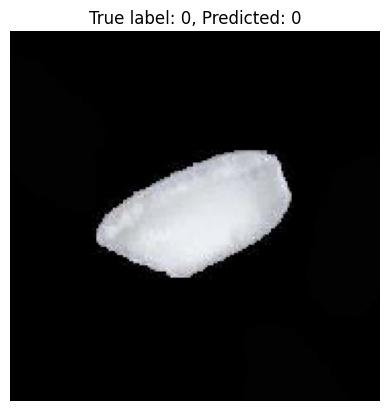

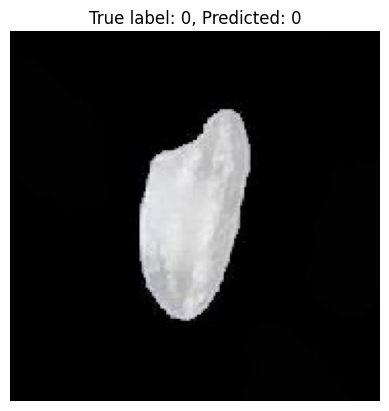

In [188]:
test_images, test_labels = next(iter(test_ds.take(1)))  
test_images = test_images[:3] 
test_labels = test_labels[:3]

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

for i in range(3):
  plt.figure()
  plt.imshow(test_images[i].numpy().astype("uint8"))
  plt.title(f"True label: {test_labels[i]}, Predicted: {predicted_labels[i]}")
  plt.axis('off')
  plt.show()

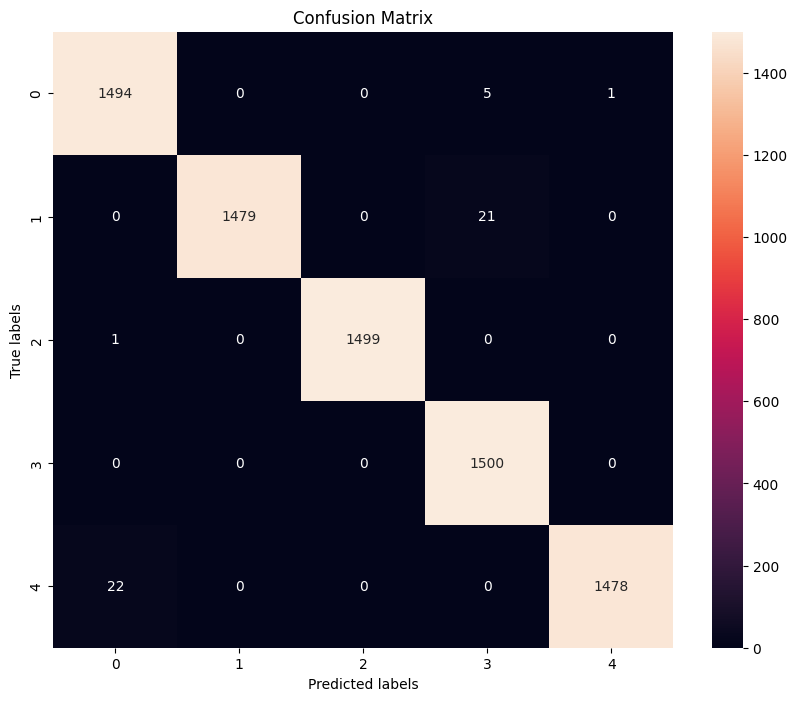

In [189]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

y_pred = [] 
y_true = []  

for image_batch, label_batch in test_ds:   
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [190]:
y_true = []
for images, labels in test_ds:
  y_true.extend(labels.numpy())

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'] 
print(classification_report(y_true, y_pred, target_names=classes))

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
              precision    recall  f1-score   support

     Arborio       0.98      1.00      0.99      1500
     Basmati       1.00      0.99      0.99      1500
      Ipsala       1.00      1.00      1.00      1500
     Jasmine       0.98      1.00      0.99      1500
   Karacadag       1.00      0.99      0.99      1500

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



In [191]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!
